# CDL by tensorflow

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>



In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pickle
import tensorflow as tf
import time

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import caffeine
#init random seed
np.random.seed(5)



## Step 1 : Generate Rating Matrix

In [3]:
# program_df = pd.read_csv("/Users/krishna/Dropbox/Data/Data/Program/correct File/csvwithHeaders/part-00000-024e4c6e-680c-49e1-8e20-667765b52332-c000.csv")
AllData_test_run = pq.read_table("/Users/krishna/Dropbox/Data/final_datasets/feature_enginnering/user_program_features/stage2/part-00000-c8f21366-ffaf-491f-837c-abaa906916b3-c000.snappy.parquet")
AllData_test_run_df = AllData_test_run.to_pandas()
AllData_test_run_df.replace("NULL", np.nan,inplace=True)
# AllData_test_run_df.replace(np.nan, 0,inplace=True)
AllData_test_run_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3494276 entries, 0 to 3494275
Data columns (total 25 columns):
USER                              int64
PROGRAM_WATCH_RATIO               float64
EPISODES_WATCHED                  int64
USER_WATCH_FREQUENCY              float64
USER_PROGRAM_PREFERANCE_METRIC    float64
MASTER_TITLE                      object
EVENT_DATE                        object
CATEGORY_ID                       object
SUBCATEGORY_ID                    object
RUNTIME                           object
EPISODE_COUNT                     object
day                               object
week_text                         object
week_encoded                      object
month                             object
vwp_days                          object
weekend                           object
daypart                           object
weekOfTheYear                     object
EVENT_END_DATE                    object
airStartDate                      object
airStartTime             

### Transpose the original Matrix to for Rating Matrix

In [4]:
AllData_test_run_pivot_df = AllData_test_run_df[["USER","MASTER_TITLE","USER_PROGRAM_PREFERANCE_METRIC"]].pivot("USER", "MASTER_TITLE", "USER_PROGRAM_PREFERANCE_METRIC")
AllData_test_run_pivot_df.replace("NULL", np.nan,inplace=True)
AllData_test_run_pivot_df.replace(np.nan, 0,inplace=True)
AllData_test_run_pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292601 entries, 5046682 to 9145409
Columns: 259 entries, A Taste of History to tasteMAKERS
dtypes: float64(259)
memory usage: 580.4 MB


In [5]:
AllData_test_run_pivot_df_Original = AllData_test_run_pivot_df.copy()

### Making one of the series Blank

In [6]:
AllData_test_run_pivot_df["The Big Bang Theory"] = 0.0
AllData_test_run_pivot_df.head()

MASTER_TITLE,A Taste of History,ALVINNN!!! and the Chipmunks,Alaska: The Last Frontier: The Frozen Edge,America Says,America's Heartland,America's Test Kitchen,American Pickers,American Woodshop,Americas Now,Arthur,...,We Bare Bears,Weekends With Yankee,Wheel of Fortune,Who Wants to Be a Millionaire,Woodsmith Shop,World Poker Tour,Yan Can Cook: Spice Kingdom,Yoga in Practice,Zak Storm,tasteMAKERS
USER,,,,,,,,,,,,,,,,,,,,,
5046682,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0
5046684,0.0,0.0,0.0,0.0,0.0,0.0,0.089691,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5046685,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5046686,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5046687,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
del AllData_test_run_df

## Step 2 : Generate document-term matrix

### Pre-processing:

In [7]:
import pickle
pickle_in = open("/Users/krishna/BDA03/AllSpark_Workspace/Project_Analysis/data_combined_265_0_articles_Jun24.pickle","rb")
# data_combined_top20_Jun28 = pickle.load(pickle_in)

data_combined = pickle.load(pickle_in)

len(data_combined)

# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(data_combined.Data.apply(round1))
# data_clean

# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.Data.apply(round2))
# data_clean

data_clean.head()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import stem

np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def return_to_str(text):
    return ' '.join(text)

# print(preprocess(data_clean['Data'][0]))
data_clean = pd.DataFrame(data_clean.Data.apply(preprocess))
data_clean = pd.DataFrame(data_clean.Data.apply(return_to_str))



[nltk_data] Downloading package wordnet to /Users/krishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
data_clean.head()

,Data
A Taste of History,tast gustatori percept gustat adjectiv form gu...
ALVINNN!!! and the Chipmunks,alvin chipmunk styliz alvinnn chipmunk america...
Alaska: The Last Frontier: The Frozen Edge,alaska frontier american realiti cabl televis ...
America Says,america say american televis game host john mi...
America's Heartland,america heartland televis program unit state a...


### CountVectorizer for document-term Matrix:

In [9]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.Data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm.head()

,aaba,aadvanc,aagaard,aaib,aakaam,aalborg,aaliyah,aaliyahdont,aaliyahfin,aaqib,...,西北政法大学,西北政法学院,超级飞侠,长安校区,陕北公学,陕西本科普通高校名单,雁塔校区,슈퍼윙스,크리미널,할아버지
A Taste of History,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALVINNN!!! and the Chipmunks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alaska: The Last Frontier: The Frozen Edge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
America Says,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
America's Heartland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data_dtm.shape

(259, 61667)

#### Rename the data :

In [11]:
item_infomation_matrix = np.array(data_dtm)
rating_matrix = np.array(AllData_test_run_pivot_df)

In [12]:
item_infomation_matrix.shape

(259, 61667)

## Step 3 : CDL - Custom function Declarations
- mask  
- add_noise  
- CDL Class 

In [13]:
#### masking noise 
#apply SDAE : we hope to reconstruct item information by masking nosie
def mask(corruption_level ,size):
    mask = np.random.binomial(1, 1 - corruption_level, [size[0],size[1]])
    return mask

def add_noise(x , corruption_level ):
    x = x * mask(corruption_level , x.shape)
    return x

In [14]:
class CDL():
    def __init__(self , rating_matrix , item_infomation_matrix, n_latent, lambda_w, lambda_n, lambda_u,lambda_v,epochs, batch_size):
        
        # model參數設定
        self.n_input = item_infomation_matrix.shape[1]
        self.n_hidden1 = 1600
        self.n_hidden2 = 800
        self.n_hidden3 = 400
        self.n_hidden4 = 200
        self.n_hidden5 = 50        
        self.k = n_latent# 50
        
        self.lambda_w = lambda_w #0.1
        self.lambda_n = lambda_n # 10
        self.lambda_u = lambda_u #1
        self.lambda_v = lambda_v #10
        
        self.drop_ratio = 0.1
        self.learning_rate = 0.01
        self.epochs = epochs #200
        self.batch_size = batch_size #256
        
        self.a = 1
        self.b =0.01
        self.P = 1
        
        self.num_u = rating_matrix.shape[0]
        self.num_v = rating_matrix.shape[1]
        
        self.Weights = {
            'w1' : tf.Variable(tf.truncated_normal( [self.n_input , self.n_hidden1] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w2' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_hidden2] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w3' : tf.Variable(tf.truncated_normal( [self.n_hidden2 , self.n_hidden3] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w4' : tf.Variable(tf.truncated_normal( [self.n_hidden3 , self.n_hidden4] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w5' : tf.Variable(tf.truncated_normal( [self.n_hidden4 , self.n_hidden5] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w6' : tf.Variable(tf.truncated_normal( [self.n_hidden5 , self.n_hidden4] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w7' : tf.Variable(tf.truncated_normal( [self.n_hidden4 , self.n_hidden3] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w8' : tf.Variable(tf.truncated_normal( [self.n_hidden3 , self.n_hidden2] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),   
            'w9' : tf.Variable(tf.truncated_normal( [self.n_hidden2 , self.n_hidden1] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w))),               
            'w10' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_input] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w)))               
        }
        self.Biases = {
            'b1' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),
            'b2' : tf.Variable( tf.zeros(shape=self.n_hidden2) ),
            'b3' : tf.Variable( tf.zeros(shape=self.n_hidden3) ),
            'b4' : tf.Variable( tf.zeros(shape=self.n_hidden4) ),
            'b5' : tf.Variable( tf.zeros(shape=self.n_hidden5) ),
            'b6' : tf.Variable( tf.zeros(shape=self.n_hidden4) ),
            'b7' : tf.Variable( tf.zeros(shape=self.n_hidden3) ),            
            'b8' : tf.Variable( tf.zeros(shape=self.n_hidden2) ),            
            'b9' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),            
            'b10' : tf.Variable( tf.zeros(shape=self.n_input) )                
        }
        
        self.item_infomation_matrix = item_infomation_matrix
        
        self.rating_matrix = rating_matrix
        
#         for i in range(self.num_u):
#             if len(np.where(self.rating_matrix[i,:]>0)[0])>0 :
# #                 x = np.random.choice(np.where(self.rating_matrix[i,:]>0)[0] , self.P)
#                 x = np.where(self.rating_matrix[i,:]>0)[0]
#             else :
#                 continue 
#             self.rating_matrix[i,:].fill(0)
#             self.rating_matrix[i,x] = 1
        
        self.confidence = np.mat(np.ones(self.rating_matrix.shape)) * self.b
        self.confidence[np.where(self.rating_matrix>0)] = self.a
        
    def encoder(self , x , drop_ratio):
        w1 = self.Weights['w1']
        b1 = self.Biases['b1']
        L1 = tf.nn.sigmoid( tf.matmul(x,w1) + b1 )
        L1 = tf.nn.dropout( L1 , keep_prob= 1 - drop_ratio )
        
        w2 = self.Weights['w2']
        b2 = self.Biases['b2']
        L2 = tf.nn.sigmoid( tf.matmul(L1,w2) + b2 )
        L2 = tf.nn.dropout(L2 , keep_prob= 1 - drop_ratio)

        w3 = self.Weights['w3']
        b3 = self.Biases['b3']
        L3 = tf.nn.sigmoid( tf.matmul(L2,w3) + b3 )
        L3 = tf.nn.dropout(L3 , keep_prob= 1 - drop_ratio)

        w4 = self.Weights['w4']
        b4 = self.Biases['b4']
        L4 = tf.nn.sigmoid( tf.matmul(L3,w4) + b4 )
        L4 = tf.nn.dropout(L4 , keep_prob= 1 - drop_ratio)

        w5 = self.Weights['w5']
        b5 = self.Biases['b5']
        L5 = tf.nn.sigmoid( tf.matmul(L4,w5) + b5 )
        L5 = tf.nn.dropout(L5 , keep_prob= 1 - drop_ratio)
        
        return L5
    
    def decoder(self , x , drop_ratio):
        w6 = self.Weights['w6']
        b6 = self.Biases['b6']
        L6 = tf.nn.sigmoid(tf.matmul(x,w6) + b6)
        L6 = tf.nn.dropout(L6 , keep_prob= 1 - drop_ratio)

        w7 = self.Weights['w7']
        b7 = self.Biases['b7']
        L7 = tf.nn.sigmoid(tf.matmul(L6,w7) + b7)
        L7 = tf.nn.dropout(L7 , keep_prob= 1 - drop_ratio)

        w8 = self.Weights['w8']
        b8 = self.Biases['b8']
        L8 = tf.nn.sigmoid(tf.matmul(L7,w8) + b8)
        L8 = tf.nn.dropout(L8 , keep_prob= 1 - drop_ratio)

        w9 = self.Weights['w9']
        b9 = self.Biases['b9']
        L9 = tf.nn.sigmoid(tf.matmul(L8,w9) + b9)
        L9 = tf.nn.dropout(L9 , keep_prob= 1 - drop_ratio)

        w10 = self.Weights['w10']
        b10 = self.Biases['b10']
        L10 = tf.nn.sigmoid(tf.matmul(L9,w10) + b10)
        L10 = tf.nn.dropout(L10 , keep_prob= 1 - drop_ratio)

        return L10
    
#     def only_MF(self):
#         self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.drop_ratio = tf.placeholder(tf.float32)
#         self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )
        
#         batch_size = tf.cast(tf.shape(self.R)[1], tf.int32)
        
        
#         self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) ) 
#         self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )
        
#         batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])
        
#         loss_1 = self.lambda_u * tf.nn.l2_loss( self.U ) 
#         loss_2 = tf.reduce_sum(tf.multiply(self.C ,
#                                     tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True))) 
#                                 )
        
#         self.loss = loss_1 + loss_2 
#         self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def build_model(self):
        
        self.X_0 = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.X_c = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.drop_ratio = tf.placeholder(tf.float32)
        self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )
        #SDAE item factor
        V_sdae = self.encoder( self.X_0 , self.drop_ratio )
        
        #SDAE output 
        sdae_output = self.decoder( V_sdae , self.drop_ratio )

        batch_size = tf.cast(tf.shape(self.X_0)[0], tf.int32)
        
        
        self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) ) 
        self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )
        
        batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])
        
        loss_1 = self.lambda_u * tf.nn.l2_loss( self.U ) 
        loss_2 = self.lambda_w * 1/2 * tf.reduce_sum([tf.nn.l2_loss(w)+tf.nn.l2_loss(b) for w,b in zip(self.Weights.values() , self.Biases.values())])
        loss_3 = self.lambda_v * tf.nn.l2_loss(batch_V - V_sdae)
        loss_4 = self.lambda_n * tf.nn.l2_loss(sdae_output - self.X_c)
        loss_5 = tf.reduce_sum(tf.multiply(self.C ,
                                           tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True))
                                          ) 
                                )
        
        self.loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def train_model(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        start_time = time.time()
        
        random_idx = np.random.permutation(self.num_v)
        
        self.item_infomation_matrix_noise = add_noise(self.item_infomation_matrix , 0.3)
        
        for epoch in range(self.epochs):
            batch_cost = 0
            for i in range(0 , self.item_infomation_matrix.shape[0] , self.batch_size):
                
                batch_idx = random_idx[i:i+self.batch_size]
                _ , loss = self.sess.run([self.optimizer, self.loss] , 
                                            feed_dict={self.X_0 : self.item_infomation_matrix_noise[batch_idx,:] , 
                                                       self.X_c : self.item_infomation_matrix[batch_idx,:] , 
                                                       self.R : self.rating_matrix[: , batch_idx], 
                                                       self.C : self.confidence[: , batch_idx], 
                                                       self.drop_ratio : 0.1 ,
                                                       self.model_batch_data_idx  : batch_idx })
                batch_cost = batch_cost + loss

            print ("Training //", "Epoch %d //" % (epoch+1), " Total cost = {:.2f}".format(batch_cost), "Elapsed time : %d sec" % (time.time() - start_time))
            
        return self.sess.run((tf.matmul(self.U, self.V, transpose_b=True)))

### Model Building :

In [ ]:
n_latent_array = [50]
lambda_w_array = [10.0]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]
combination_array = []

for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )
R_train = rating_matrix.copy()
result_array,CDL_array = [],[]
for i in range(len(combination_array)):
    n_lat = combination_array[i][0]
    lam_w = combination_array[i][1]
    lam_n = combination_array[i][2]
    lam_u = combination_array[i][3]
    lam_v = combination_array[i][4]    
    epoch = combination_array[i][5]
    batch = combination_array[i][6]
    print('Model - {} : Creating model for \n{} - topics,\n{} - lambda_w, \n{} - lambda_n, \n{} - lambda_u, \n{} - lambda_v, \n{} - epochs, \n{} - batchsize'.\
          format(i,n_lat,lam_w,lam_n,lam_u,lam_v,epoch,batch))
    cdl_model = CDL(R_train,item_infomation_matrix,n_lat,lam_w,lam_n,lam_u,lam_v,epoch, batch)
    cdl_model.build_model()
    result_array.append(cdl_model.train_model())
    print('Model - {} : Done'.format(i))
#     CDL_array.append(cdl_model)

## Step 4 : Storing and reading the models and Model Results:

In [15]:
import pickle
# pickle_out = open("CDL_result_array_50_10[w]_ALL_COMB_500.pickle","wb")
# pickle.dump(result_array, pickle_out)
# pickle_out.close()

pickle_in = open("CDL_result_array_50_10[w]_ALL_COMB_500.pickle","rb")
result_array_50_10_w = pickle.load(pickle_in) 

pickle_in = open("CDL_result_array_50_0.1[w]_ALL_COMB_500.pickle","rb")
result_array_50_01_w = pickle.load(pickle_in) 

result_array = result_array_50_01_w + result_array_50_10_w

combination_array = []

n_latent_array = [50]
lambda_w_array = [0.1]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]

combination_array_1 = []
for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array_1.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )

n_latent_array = [50]
lambda_w_array = [10]
lambda_n_array = [0.1,10.0]
lambda_u_array = [0.1,10.0]
lambda_v_array = [0.1,10.0]
epochs = [500]
batch_size = [64]

combination_array_2 = []
for g in range(len(n_latent_array)):
    for h in range(len(lambda_w_array)):
        for i in range(len(lambda_n_array)):
            for j in range(len(lambda_u_array)):
                for k in range(len(lambda_v_array)):
                    for l in range(len(epochs)):
                        for m in range(len(batch_size)):
                            combination_array_2.append([n_latent_array[g],
                                                      lambda_w_array[h],
                                                      lambda_n_array[i],
                                                      lambda_u_array[j],
                                                      lambda_v_array[k],
                                                      epochs[l],
                                                      batch_size[m]]
                                                    )

                            
combination_array = combination_array_1 + combination_array_2
# CDL_result_array_50_0.1[w]_ALL_COMB_500.pickle
# n_latent_array = [50]
# lambda_w_array = [0.1]
# lambda_n_array = [0.1,10.0]
# lambda_u_array = [0.1,10.0]
# lambda_v_array = [0.1,10.0]
# epochs = [500]
# batch_size = [64]

## Step 5 : Analyzing Recall@TopM (using multiprocessing):

In [16]:
import multiprocessing
recall_list = multiprocessing.Array('f',100)

In [17]:
def calculate_recall(inp_original_arr,inp_predicted_arr,inp_threshold) :
    
    def calculations(original_arr,predicted_arr,threshold,recall_list): 
        for i in range(len(original_arr)):
            zero_loc = np.where(original_arr[i,:] == 0)[0]
            rank_10 = np.argsort(original_arr[i,:])
            rank_10_pred = np.argsort(predicted_arr[i,:])[-threshold:]
            actual_likes = sum([1 for j in rank_10 if j not in zero_loc])
            if threshold < actual_likes :
                actual_likes_new = threshold
            else :
                actual_likes_new = actual_likes
            pred_likes = sum([1 for k in range(-actual_likes_new,0) if rank_10_pred[k] in rank_10[-actual_likes_new:]])
            if actual_likes_new != 0:
                recall_list.append(pred_likes/actual_likes)
            else:
                recall_list.append(0.0)

    import multiprocessing
    procs = 1   # Number of processes to create
    manager = multiprocessing.Manager()
    recall_list = manager.list()
#     recall_list = multiprocessing.Array('f',len(inp_original_arr))
    jobs = []
    for i in range(0, procs):
        process = multiprocessing.Process(target=calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,recall_list))
        jobs.append(process)
    for j in jobs:
        j.start()
    for j in jobs:
        j.join()
    print("List processing complete.")
    return recall_list

In [18]:
watched = pd.Series([ len([i for i in row.values if i>0.0]) for row_index,row in AllData_test_run_pivot_df_Original.iterrows() ])

In [21]:
start = time.time()
result_df = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],10)
end = time.time()
print('Duration in Min : ', (end-start)/60)
result_df.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
Duration in Min :  91.31787504752477


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v,Model_150_topics0.1_w0.1_n0.1_u10.0_v,Model_250_topics0.1_w0.1_n10.0_u0.1_v,Model_350_topics0.1_w0.1_n10.0_u10.0_v,Model_450_topics0.1_w10.0_n0.1_u0.1_v,Model_550_topics0.1_w10.0_n0.1_u10.0_v,Model_650_topics0.1_w10.0_n10.0_u0.1_v,Model_750_topics0.1_w10.0_n10.0_u10.0_v,Model_850_topics10_w0.1_n0.1_u0.1_v,Model_950_topics10_w0.1_n0.1_u10.0_v,Model_1050_topics10_w0.1_n10.0_u0.1_v,Model_1150_topics10_w0.1_n10.0_u10.0_v,Model_1250_topics10_w10.0_n0.1_u0.1_v,Model_1350_topics10_w10.0_n0.1_u10.0_v,Model_1450_topics10_w10.0_n10.0_u0.1_v,Model_1550_topics10_w10.0_n10.0_u10.0_v
0,19,0.421053,0.421053,0.210526,0.263158,0.473684,0.368421,0.315789,0.263158,0.368421,0.315789,0.263158,0.263158,0.473684,0.315789,0.263158,0.263158
1,50,0.100000,0.080000,0.120000,0.080000,0.120000,0.140000,0.120000,0.120000,0.080000,0.120000,0.100000,0.120000,0.120000,0.140000,0.080000,0.120000
2,10,0.600000,0.600000,0.700000,0.600000,0.700000,0.500000,0.400000,0.500000,0.700000,0.800000,0.400000,0.500000,0.600000,0.600000,0.400000,0.600000
3,4,0.500000,0.250000,0.250000,0.250000,0.500000,0.000000,0.000000,0.250000,0.500000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [22]:
start = time.time()
result_df_5 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df_5[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],5)
end = time.time()
print('Duration in Min : ', (end-start)/60)    
result_df_5.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
Duration in Min :  81.20808582305908


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v,Model_150_topics0.1_w0.1_n0.1_u10.0_v,Model_250_topics0.1_w0.1_n10.0_u0.1_v,Model_350_topics0.1_w0.1_n10.0_u10.0_v,Model_450_topics0.1_w10.0_n0.1_u0.1_v,Model_550_topics0.1_w10.0_n0.1_u10.0_v,Model_650_topics0.1_w10.0_n10.0_u0.1_v,Model_750_topics0.1_w10.0_n10.0_u10.0_v,Model_850_topics10_w0.1_n0.1_u0.1_v,Model_950_topics10_w0.1_n0.1_u10.0_v,Model_1050_topics10_w0.1_n10.0_u0.1_v,Model_1150_topics10_w0.1_n10.0_u10.0_v,Model_1250_topics10_w10.0_n0.1_u0.1_v,Model_1350_topics10_w10.0_n0.1_u10.0_v,Model_1450_topics10_w10.0_n10.0_u0.1_v,Model_1550_topics10_w10.0_n10.0_u10.0_v
0,19,0.263158,0.263158,0.157895,0.157895,0.210526,0.157895,0.105263,0.157895,0.210526,0.210526,0.210526,0.105263,0.210526,0.210526,0.105263,0.157895
1,50,0.060000,0.040000,0.020000,0.040000,0.040000,0.080000,0.040000,0.060000,0.020000,0.060000,0.040000,0.060000,0.060000,0.080000,0.020000,0.060000
2,10,0.400000,0.400000,0.300000,0.300000,0.400000,0.400000,0.200000,0.300000,0.400000,0.400000,0.300000,0.300000,0.300000,0.400000,0.400000,0.300000
3,4,0.500000,0.250000,0.250000,0.250000,0.500000,0.000000,0.000000,0.250000,0.500000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [47]:
start = time.time()
result_df_15 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df_15[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],15)
end = time.time()
print('Duration in Min : ', (end-start)/60)    
result_df_15.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
Duration in Min :  88.38173178434371


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v,Model_150_topics0.1_w0.1_n0.1_u10.0_v,Model_250_topics0.1_w0.1_n10.0_u0.1_v,Model_350_topics0.1_w0.1_n10.0_u10.0_v,Model_450_topics0.1_w10.0_n0.1_u0.1_v,Model_550_topics0.1_w10.0_n0.1_u10.0_v,Model_650_topics0.1_w10.0_n10.0_u0.1_v,Model_750_topics0.1_w10.0_n10.0_u10.0_v,Model_850_topics10_w0.1_n0.1_u0.1_v,Model_950_topics10_w0.1_n0.1_u10.0_v,Model_1050_topics10_w0.1_n10.0_u0.1_v,Model_1150_topics10_w0.1_n10.0_u10.0_v,Model_1250_topics10_w10.0_n0.1_u0.1_v,Model_1350_topics10_w10.0_n0.1_u10.0_v,Model_1450_topics10_w10.0_n10.0_u0.1_v,Model_1550_topics10_w10.0_n10.0_u10.0_v
0,19,0.473684,0.473684,0.368421,0.315789,0.526316,0.421053,0.315789,0.263158,0.421053,0.473684,0.263158,0.263158,0.526316,0.421053,0.421053,0.263158
1,50,0.140000,0.120000,0.120000,0.080000,0.140000,0.140000,0.160000,0.140000,0.120000,0.120000,0.120000,0.120000,0.160000,0.140000,0.180000,0.140000
2,10,0.600000,0.600000,0.700000,0.600000,0.700000,0.500000,0.400000,0.500000,0.700000,0.800000,0.400000,0.500000,0.600000,0.600000,0.400000,0.600000
3,4,0.500000,0.250000,0.250000,0.250000,0.500000,0.000000,0.000000,0.250000,0.500000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [48]:
start = time.time()
result_df_20 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    result_df_20[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],20)
end = time.time()
print('Duration in Min : ', (end-start)/60)    
result_df_20.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
Duration in Min :  93.7951540350914


,watched,Model_050_topics0.1_w0.1_n0.1_u0.1_v,Model_150_topics0.1_w0.1_n0.1_u10.0_v,Model_250_topics0.1_w0.1_n10.0_u0.1_v,Model_350_topics0.1_w0.1_n10.0_u10.0_v,Model_450_topics0.1_w10.0_n0.1_u0.1_v,Model_550_topics0.1_w10.0_n0.1_u10.0_v,Model_650_topics0.1_w10.0_n10.0_u0.1_v,Model_750_topics0.1_w10.0_n10.0_u10.0_v,Model_850_topics10_w0.1_n0.1_u0.1_v,Model_950_topics10_w0.1_n0.1_u10.0_v,Model_1050_topics10_w0.1_n10.0_u0.1_v,Model_1150_topics10_w0.1_n10.0_u10.0_v,Model_1250_topics10_w10.0_n0.1_u0.1_v,Model_1350_topics10_w10.0_n0.1_u10.0_v,Model_1450_topics10_w10.0_n10.0_u0.1_v,Model_1550_topics10_w10.0_n10.0_u10.0_v
0,19,0.473684,0.473684,0.368421,0.368421,0.526316,0.421053,0.368421,0.368421,0.421053,0.473684,0.263158,0.368421,0.578947,0.421053,0.473684,0.368421
1,50,0.160000,0.160000,0.140000,0.100000,0.200000,0.160000,0.200000,0.180000,0.140000,0.140000,0.140000,0.180000,0.180000,0.180000,0.220000,0.180000
2,10,0.600000,0.600000,0.700000,0.600000,0.700000,0.500000,0.400000,0.500000,0.700000,0.800000,0.400000,0.500000,0.600000,0.600000,0.400000,0.600000
3,4,0.500000,0.250000,0.250000,0.250000,0.500000,0.000000,0.000000,0.250000,0.500000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [52]:
pickle_out = open("CDL_result_df_5.pickle","wb")
pickle.dump(result_df_5, pickle_out)
pickle_out.close()

pickle_out = open("CDL_result_df_15.pickle","wb")
pickle.dump(result_df_15, pickle_out)
pickle_out.close()

pickle_out = open("CDL_result_df_20.pickle","wb")
pickle.dump(result_df_20, pickle_out)
pickle_out.close()

pickle_out = open("CDL_result_df_10.pickle","wb")
pickle.dump(result_df, pickle_out)
pickle_out.close()

Text(0, 0.5, 'Users Count')

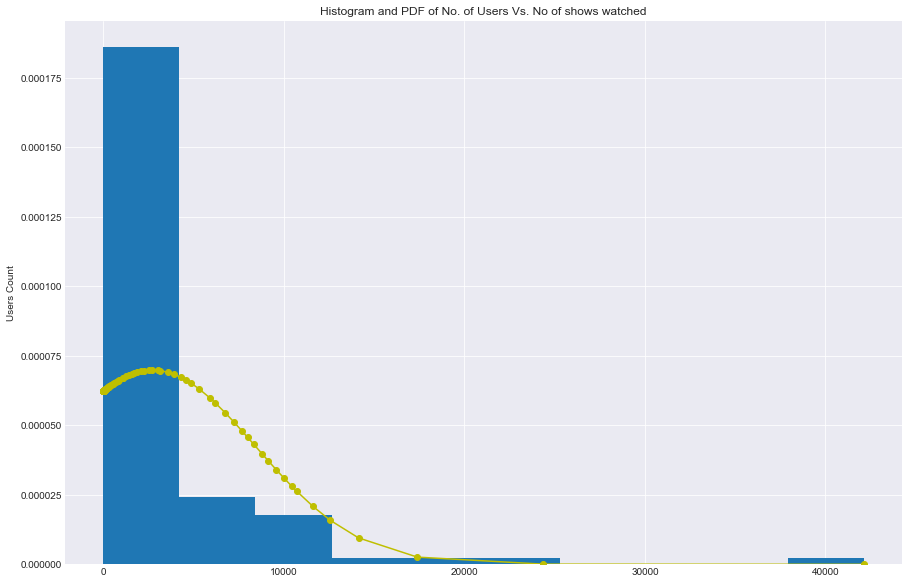

In [147]:
import scipy.stats as stats
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))
# ,'Model_050_topics0.1_w0.1_n0.1_u0.1_v'

result_df_bar = pd.DataFrame({"watched":watched})
result_df_bar.reset_index(inplace = True)
res_df = result_df_bar[['watched','index']].groupby('watched').count().reset_index()
h = res_df['index']
plt.hist(h,density=True)
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'yo-')
# sns.kdeplot(res_df['watched'], color='b', shade=True) 
plt.title('Histogram and PDF of No. of Users Vs. No of shows watched') 
# plt.xlabel('Watched')
plt.ylabel('Users Count') 

In [148]:
res_df['cumul_sum'] = res_df['index'].cumsum()
res_df['pct'] = res_df['cumul_sum']/292601
res_df.head(20)

,watched,index,cumul_sum,pct
0,1,42142,42142,0.144025
1,2,24381,66523,0.227351
2,3,17398,83921,0.286810
3,4,14140,98061,0.335136
4,5,12576,110637,0.378116
5,6,11621,122258,0.417832
6,7,10704,132962,0.454414
7,8,10430,143392,0.490060
8,9,10005,153397,0.524253
9,10,9576,162973,0.556980


In [260]:
# plt.figure(figsize= (15,10))
# plt.plot('watched','pct','o-',data = res_df)
# # plt.scatter('watched',  'Model_1250_topics10_w10.0_n0.1_u0.1_v' ,data=result_df,c='g')
# plt.plot(result_df[['watched','Model_1250_topics10_w10.0_n0.1_u0.1_v']].groupby('watched').mean().reset_index()['watched'], 
#          result_df[['watched','Model_1250_topics10_w10.0_n0.1_u0.1_v']].groupby('watched').mean().reset_index()['Model_1250_topics10_w10.0_n0.1_u0.1_v'], 
#          marker='.', color=palette(num), linewidth=1, alpha=0.9)
# mean_val  = np.mean(result_df['Model_1250_topics10_w10.0_n0.1_u0.1_v'])
# plt.plot(result_df['watched'],[mean_val for i in range(len(result_df['watched']))], 'r*')

# # plt.title('Perceentage of people vs no of shows watched')
# plt.legend()

Text(0, 0.5, 'Recall')

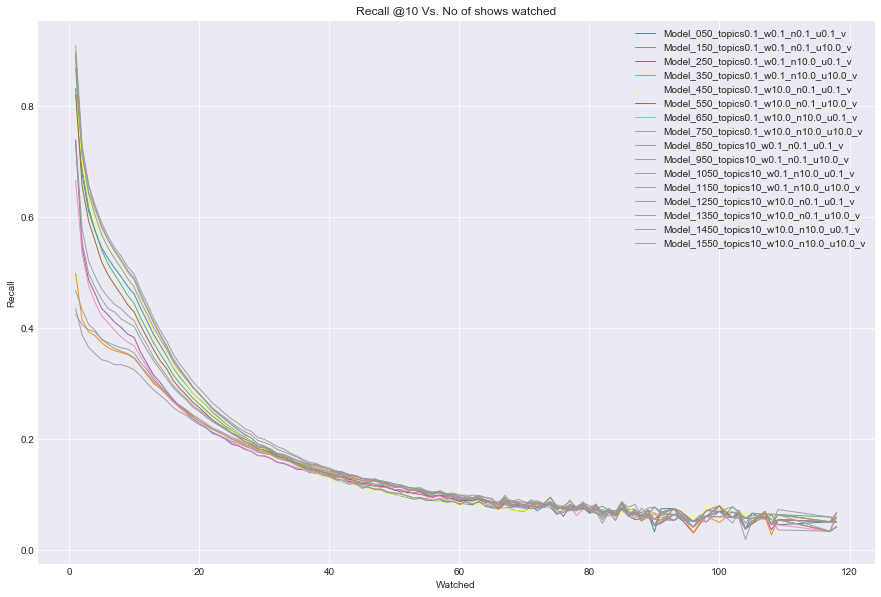

In [25]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df.columns[1:]:
    num+=1
    res_df = result_df[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @10 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

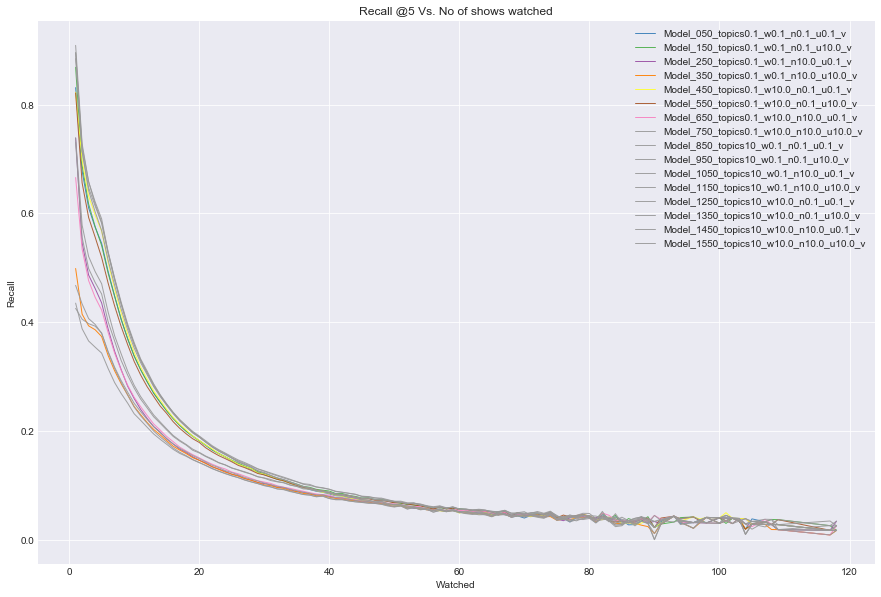

In [138]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df_5.columns[1:]:
    num+=1
    res_df = result_df_5[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @5 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

In [ ]:
# style
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))

num=0
for column in result_df_15.columns[1:]:
    num+=1
    res_df = result_df_15[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall @15 Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

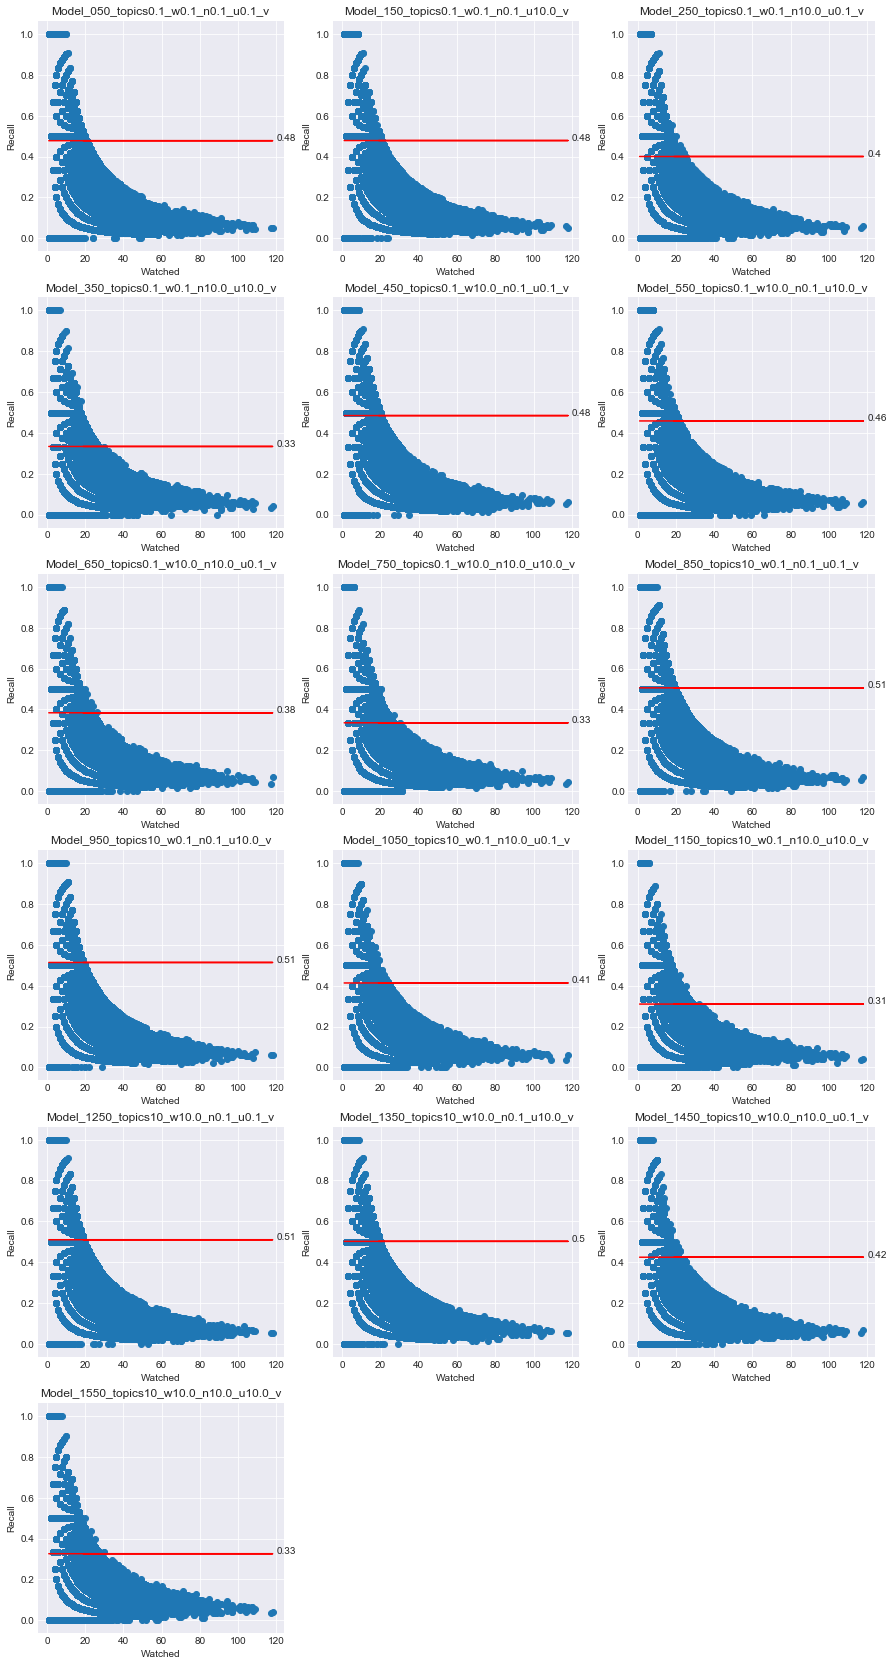

In [27]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
    plt.title(model_string)
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df)
    mean_val  = np.mean(result_df[model_string])
    plt.plot(result_df['watched'],[mean_val for i in range(len(result_df['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))


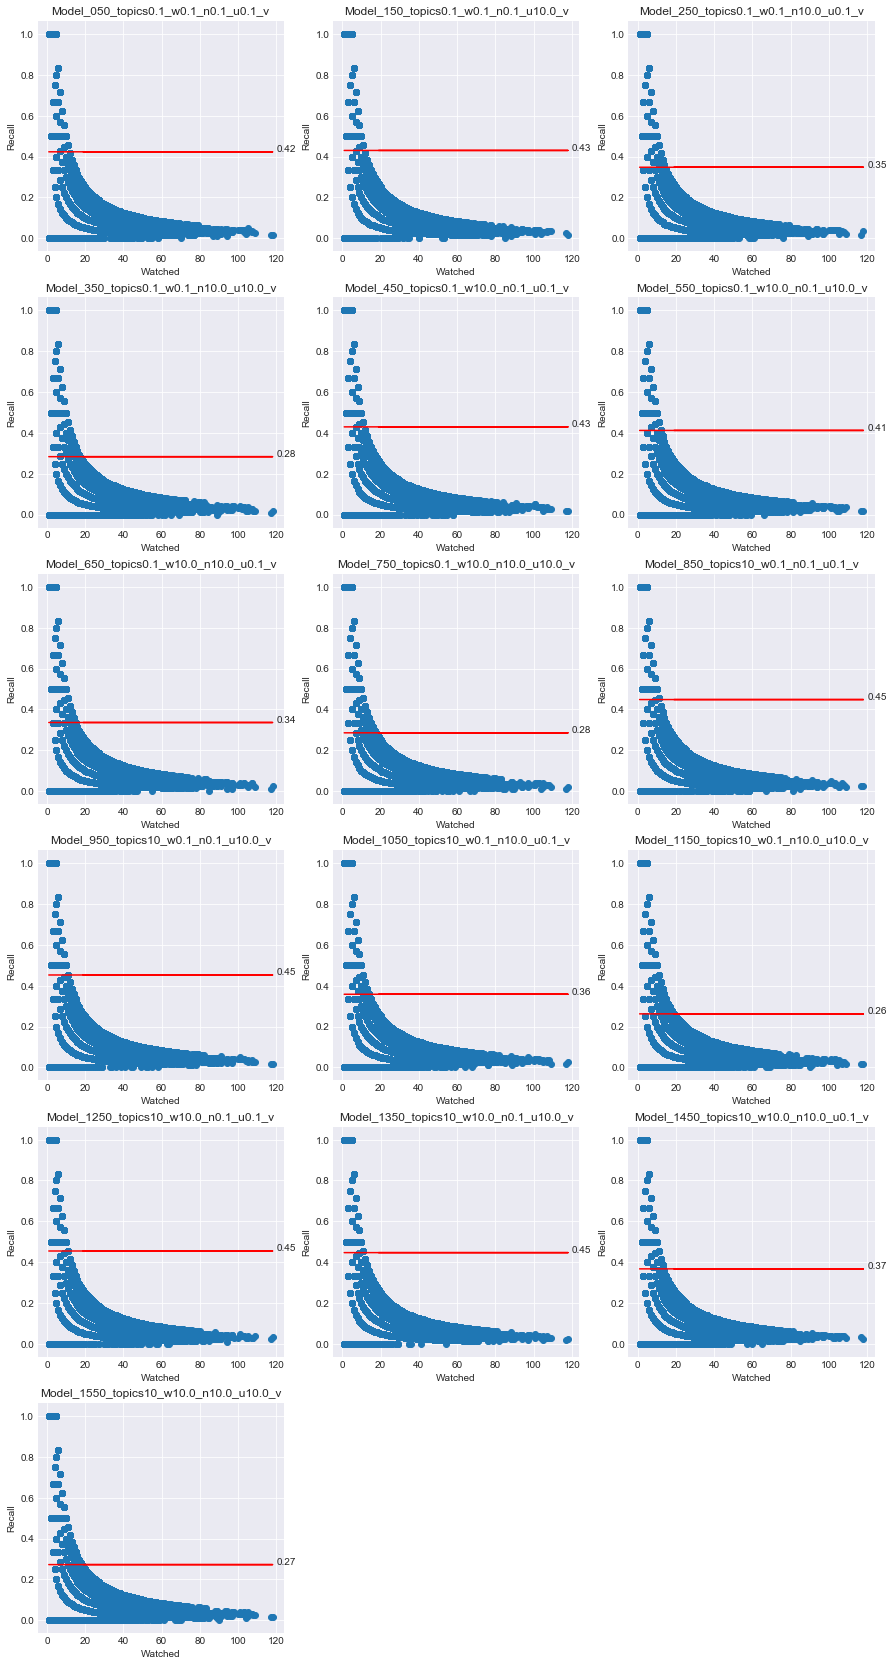

In [28]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df_5)
    plt.title(model_string)
    mean_val  = np.mean(result_df_5[model_string])
    plt.plot(result_df_5['watched'],[mean_val for i in range(len(result_df_5['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))

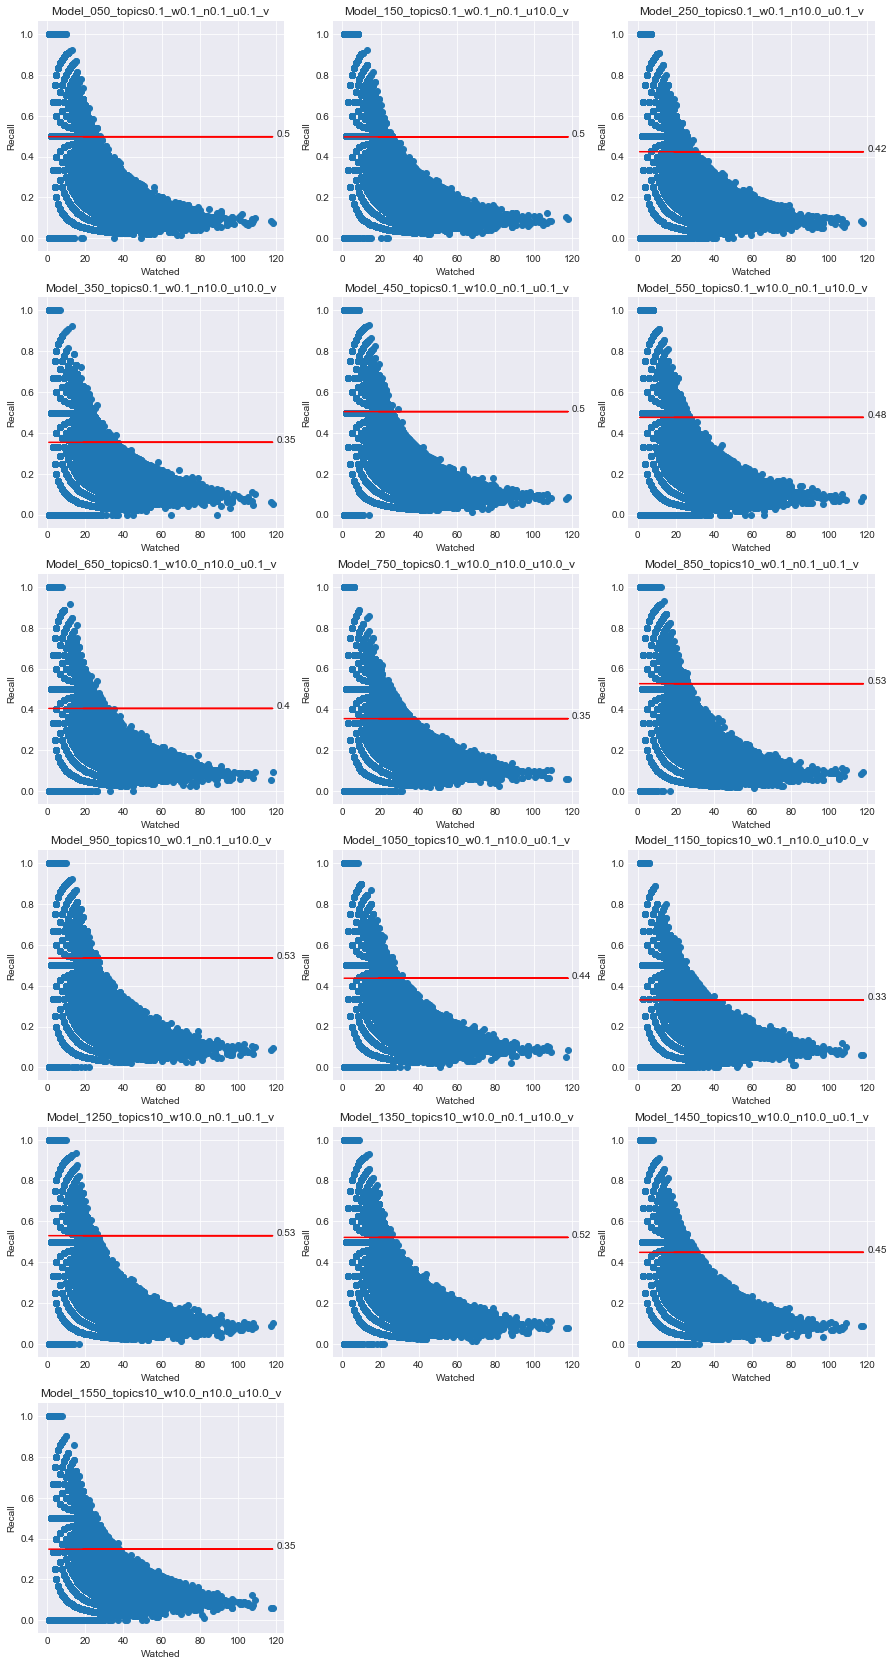

In [54]:
plt.figure(figsize=(15,50))
plt.title('Recall vs Watched by model & Avg. Recall') 
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df_15)
    plt.title(model_string)
    mean_val  = np.mean(result_df_15[model_string])
    plt.plot(result_df_15['watched'],[mean_val for i in range(len(result_df_15['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))

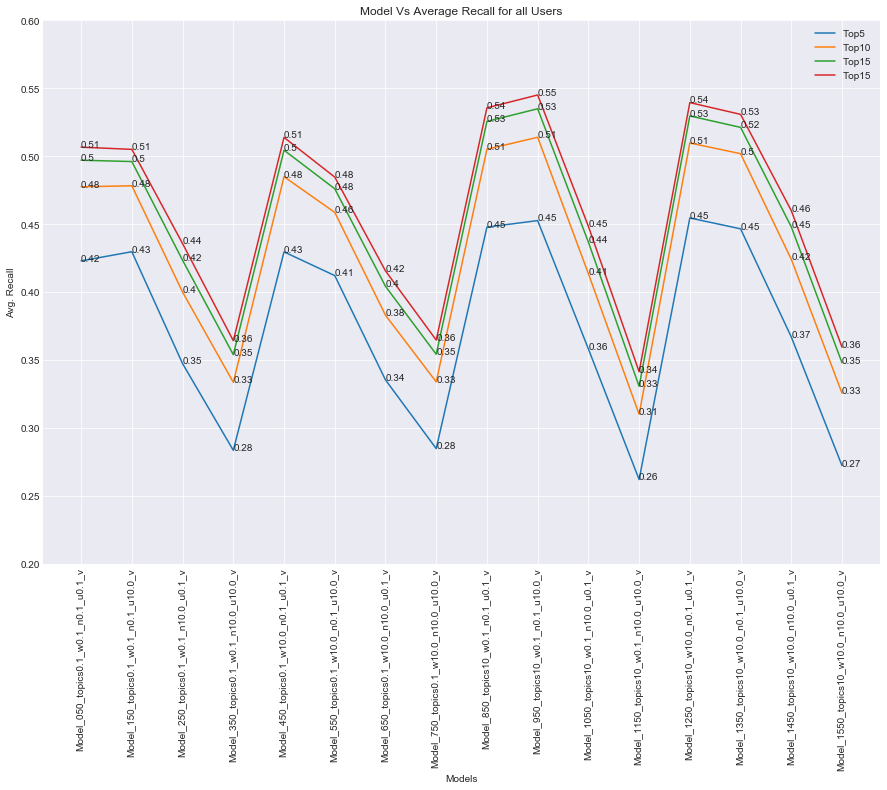

In [173]:
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
avg_recall_df = pd.DataFrame(result_df[result_df.columns[result_df.columns != 'watched']].mean().reset_index())
avg_recall_df_5 = pd.DataFrame(result_df_5[result_df_5.columns[result_df_5.columns != 'watched']].mean().reset_index())
avg_recall_df_15 = pd.DataFrame(result_df_15[result_df_15.columns[result_df_15.columns != 'watched']].mean().reset_index())
avg_recall_df_20 = pd.DataFrame(result_df_20[result_df_20.columns[result_df_20.columns != 'watched']].mean().reset_index())

avg_recall_df.columns = ['name','sum']
avg_recall_df_5.columns = ['name','sum']
avg_recall_df_15.columns = ['name','sum']
avg_recall_df_20.columns = ['name','sum']

original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
avg_recall_df['original'] = [original_watchers for i in range(len(avg_recall_df))]
avg_recall_df_5['original'] = [original_watchers for i in range(len(avg_recall_df_5))]
avg_recall_df_15['original'] = [original_watchers for i in range(len(avg_recall_df_15))]
avg_recall_df_20['original'] = [original_watchers for i in range(len(avg_recall_df_20))]
# avg_recall_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in avg_recall_df.name ]
plt.figure(figsize = (15,10))

plt.plot('name','sum',data = avg_recall_df_5,label = 'Top5')
for i,j in zip(range(len(avg_recall_df_5.name)),avg_recall_df_5['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
plt.plot('name','sum',data = avg_recall_df, label = 'Top10')
for i,j in zip(range(len(avg_recall_df.name)),avg_recall_df['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
plt.plot('name','sum',data = avg_recall_df_15,label ='Top15')
for i,j in zip(range(len(avg_recall_df_15.name)),avg_recall_df_15['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))
plt.plot('name','sum',data = avg_recall_df_20,label ='Top15')
for i,j in zip(range(len(avg_recall_df_20.name)),avg_recall_df_20['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j))    
    
plt.title("Model Vs Average Recall for all Users")
plt.xlabel("Models")
plt.ylabel("Avg. Recall")
plt.xticks(rotation = 90)
plt.ylim([0.2,0.6])
plt.legend()

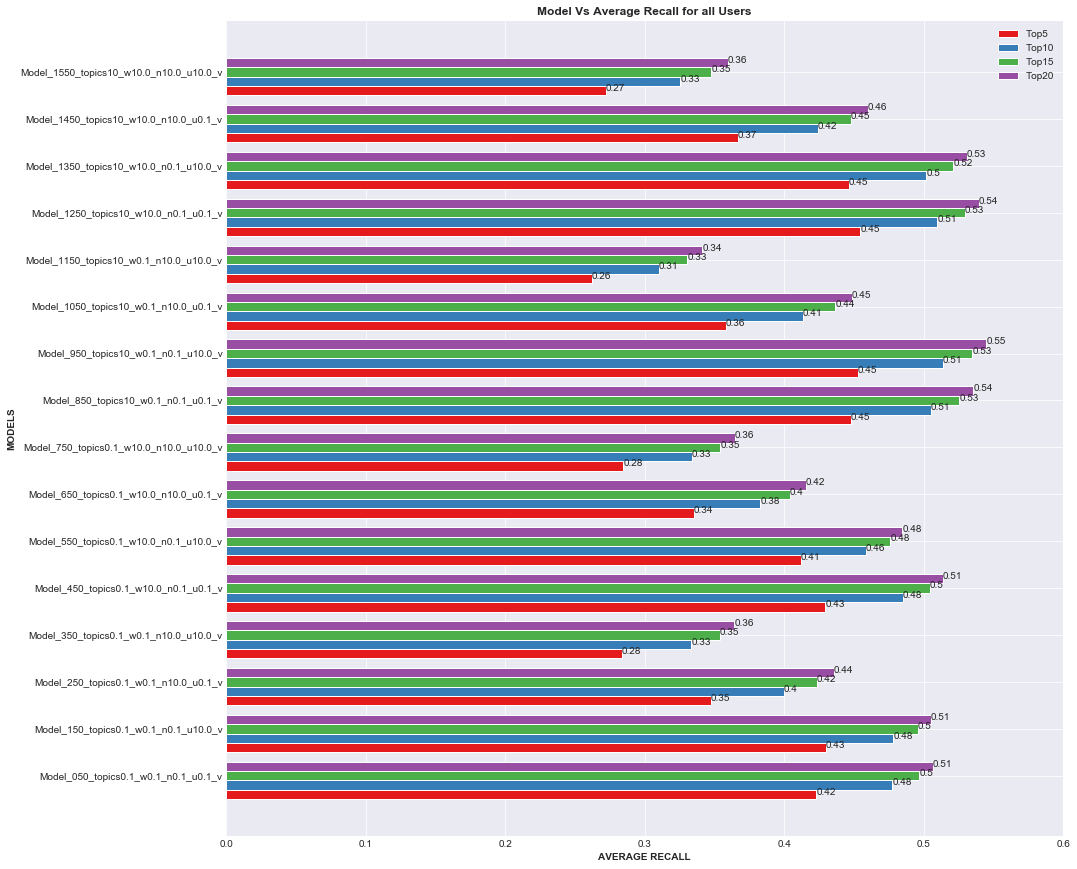

In [291]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.2

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0 
# set height of bar
bars1 = avg_recall_df_5['sum']
bars2 = avg_recall_df['sum']
bars3 = avg_recall_df_15['sum']
bars4 = avg_recall_df_20['sum']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(15,15))
# Make the plot
plt.barh(r1, bars1, barWidth, color=palette(num), edgecolor='white', label='Top5')
plt.barh(r2, bars2, barWidth, color=palette(num+1), edgecolor='white', label='Top10')
plt.barh(r3, bars3, barWidth, color=palette(num+2), edgecolor='white', label='Top15')
plt.barh(r4, bars4, barWidth, color=palette(num+3), edgecolor='white', label='Top20')

for i,j in zip(bars1,r1):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars2,r2):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars3,r3):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars4,r4):
    plt.annotate(str(round(i,2)),xy=(i,j))

model_array = ['Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"   \
 for i in range(len(result_array))]
 
# Add xticks on the middle of the group bars

plt.yticks([r + barWidth*2 for r in range(len(bars1))], model_array)
plt.title("Model Vs Average Recall for all Users",fontweight='bold', fontsize=12)
plt.ylabel("MODELS",fontweight='bold', fontsize=10)
plt.xlabel("AVERAGE RECALL",fontweight='bold', fontsize=10) 
plt.xlim([0,0.6])
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.savefig('/Users/krishna/Desktop/Images/CDL_Model_Results.png',bbox_inches='tight')

In [60]:
avg_recall_by_M = pd.merge(avg_recall_df,avg_recall_df_5, on = 'name',suffixes=['_10', '_5'])
avg_recall_by_M = pd.merge(avg_recall_by_M,avg_recall_df_15, on = 'name',suffixes=['_Old', '_15'])
avg_recall_by_M = pd.merge(avg_recall_by_M,avg_recall_df_20, on = 'name',suffixes=['_Old', '_20'])
avg_recall_by_M.columns = ['name','10','total_10','5','total_5','15','total_15','20','total_20']
avg_recall_by_M.drop(['total_10','total_15','total_5','total_20'],axis = 1,inplace = True)
avg_recall_by_M

,name,10,5,15,20
0,Model_050_topics0.1_w0.1_n0.1_u0.1_v,0.477506,0.422992,0.497071,0.506664
1,Model_150_topics0.1_w0.1_n0.1_u10.0_v,0.478245,0.429732,0.496077,0.505049
2,Model_250_topics0.1_w0.1_n10.0_u0.1_v,0.400021,0.347398,0.423457,0.435697
3,Model_350_topics0.1_w0.1_n10.0_u10.0_v,0.333633,0.283582,0.353991,0.364277
4,Model_450_topics0.1_w10.0_n0.1_u0.1_v,0.484934,0.429610,0.504438,0.513844
5,Model_550_topics0.1_w10.0_n0.1_u10.0_v,0.458670,0.412165,0.476066,0.484647
6,Model_650_topics0.1_w10.0_n10.0_u0.1_v,0.383024,0.335416,0.404278,0.415614
7,Model_750_topics0.1_w10.0_n10.0_u10.0_v,0.333949,0.284852,0.354287,0.364728
8,Model_850_topics10_w0.1_n0.1_u0.1_v,0.505134,0.447817,0.525616,0.535615
9,Model_950_topics10_w0.1_n0.1_u10.0_v,0.513948,0.452649,0.534921,0.545067


In [61]:
avg_recall_by_M_T = avg_recall_by_M[['name','5','10','15','20']].T
avg_recall_by_M_T.columns = avg_recall_by_M_T.iloc[0,:]
avg_recall_by_M_T.drop('name',inplace = True)

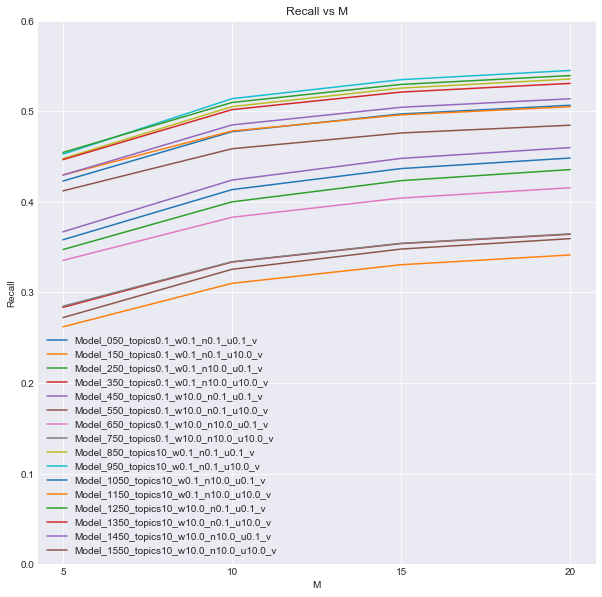

In [261]:
plt.figure(figsize = (10,10))
for i in avg_recall_by_M_T.columns:
    plt.plot(avg_recall_by_M_T.index,avg_recall_by_M_T[i],label=str(i))
#     for i,j in zip(range(len(avg_recall_by_M_T.index)),avg_recall_by_M_T[i]):
#         plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)

plt.ylim([0,0.6])
plt.xlabel('M')
plt.ylabel('Recall')
plt.title('Recall vs M')
plt.legend()

In [49]:
# present_list = []
def calculate_present_or_not(inp_original_arr,inp_predicted_arr,inp_threshold,inp_series_loc) :

    def present_calculations(original_arr,predicted_arr,threshold,present_list,series_loc): 
        for i in range(len(original_arr)):
            rank_10 = np.argsort(original_arr[i,:])[-threshold:]
            if (predicted_arr[i,series_loc] > np.min(predicted_arr[i,:][rank_10])) and (original_arr[i,series_loc] > 0.0):
                present_list.append(1)
            else:
                present_list.append(0)
            
    import multiprocessing
    procs = 1   # Number of processes to create
    manager = multiprocessing.Manager()
    present_list = manager.list()
    jobs = []
        # recall_list = list()
    for i in range(0, procs):
        process = multiprocessing.Process(target=present_calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,present_list,inp_series_loc))
        jobs.append(process)
    for j in jobs:
        j.start()
    for j in jobs:
        j.join()
    print("List processing complete.")
    return present_list

In [50]:
def generate_present_or_not(n_top, series_location,dataframe):
    for i in range(len(result_array)):
        model_string = 'Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"      
        column_name  = model_string+'_Top'+str(n_top)
        dataframe[column_name] = calculate_present_or_not(AllData_test_run_pivot_df_Original,result_array[i],n_top,series_location)

In [51]:
start = time.time()
present_or_not_df = pd.DataFrame({"watched":watched})
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
generate_present_or_not(5, series_loc,present_or_not_df)
generate_present_or_not(10, series_loc,present_or_not_df)
generate_present_or_not(15, series_loc,present_or_not_df)
generate_present_or_not(20, series_loc,present_or_not_df)
end = time.time()
print('Duration in Min : ', (end-start)/60)    

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List process

In [282]:
final_df = pd.DataFrame(present_or_not_df[present_or_not_df.columns[present_or_not_df.columns != 'watched']].sum().reset_index())
final_df.columns = ['name','sum']
original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
final_df['original'] = [original_watchers for i in range(len(final_df))]
final_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in final_df.name ]

top5_data =  [name_val.endswith('_Top5') for name_val in final_df.name]
top10_data = [name_val.endswith('_Top10') for name_val in final_df.name]
top15_data = [name_val.endswith('_Top15') for name_val in final_df.name]
top20_data = [name_val.endswith('_Top20') for name_val in final_df.name]

final_df['pct'] = final_df['sum']/final_df['original']
final_top5_data = final_df[top5_data].reset_index()
final_top10_data = final_df[top10_data].reset_index()
final_top15_data = final_df[top15_data].reset_index()
final_top20_data = final_df[top20_data].reset_index()

final_top5_data_tbbt = final_top5_data.copy()
final_top10_data_tbbt = final_top10_data.copy()
final_top15_data_tbbt = final_top15_data.copy()
final_top20_data_tbbt = final_top20_data.copy()
# plt.figure(figsize = (15,10))
# plt.plot('index_column', 'pct' ,data=final_top5_data,label = 'Top5')
# plt.plot('index_column', 'pct' ,data=final_top10_data,label = 'Top10')
# plt.plot('index_column', 'pct' ,data=final_top15_data,label = 'Top15')
# plt.plot('index_column', 'pct' ,data=final_top20_data,label = 'Top20')

# for i,j in zip(range(len(final_top5_data.index_column)),final_top5_data['pct']):
#     plt.annotate(str(round(j,2)),xy=(i,j))

# for i,j in zip(range(len(final_top10_data.index_column)),final_top10_data['pct']):
#     plt.annotate(str(round(j,2)),xy=(i,j))

# for i,j in zip(range(len(final_top15_data.index_column)),final_top15_data['pct']):
#     plt.annotate(str(round(j,2)),xy=(i,j))

# for i,j in zip(range(len(final_top20_data.index_column)),final_top20_data['pct']):
#     plt.annotate(str(round(j,2)),xy=(i,j))

# plt.ylabel('Percentage of Actual Watchers') 
# plt.title('Percentage of Actual Watchers by Model')    
# plt.xlabel('Models')
# plt.xticks(rotation=90)
# plt.ylim([0,1])

# plt.legend()        

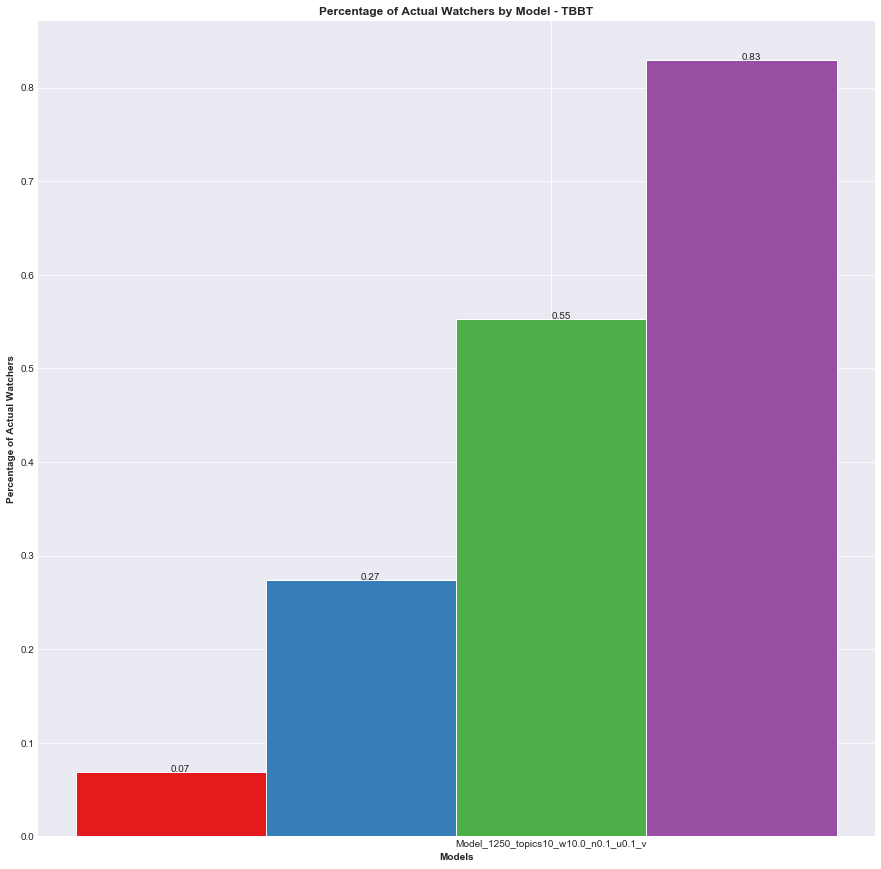

In [285]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.2

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0 
# set height of bar
bars1 = final_top5_data[final_top5_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top5']['pct']
bars2 = final_top10_data[final_top10_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top10']['pct']
bars3 = final_top15_data[final_top15_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top15']['pct']
bars4 = final_top20_data[final_top20_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top20']['pct']

# bars1 = final_top5_data['pct']
# bars2 = final_top10_data['pct']
# bars3 = final_top15_data['pct']
# bars4 = final_top20_data['pct']
    
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(15,15))
# Make the plot
plt.bar(r1, bars1, width = barWidth, color=palette(num),  edgecolor='white', label='Top5')
plt.bar(r2, bars2, width = barWidth, color=palette(num+1), edgecolor='white', label='Top10')
plt.bar(r3, bars3, width = barWidth, color=palette(num+2), edgecolor='white', label='Top15')
plt.bar(r4, bars4, width = barWidth, color=palette(num+3), edgecolor='white', label='Top20')

for i,j in zip(r1,bars1):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r2,bars2):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r3,bars3):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r4,bars4):
    plt.annotate(str(round(j,2)),xy=(i,j))

# model_array = ['Model_'+str(i)+\
#                     str(combination_array[i][0])+"_topics"+\
#                     str(combination_array[i][1])+"_u"+\
#                     str(combination_array[i][2])+"_v"
#  for i in range(len(result_array))]
model_array = ['Model_1250_topics10_w10.0_n0.1_u0.1_v']
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth*2 for r in range(len(bars1))], model_array )
plt.ylabel('Percentage of Actual Watchers',fontweight='bold') 
plt.title('Percentage of Actual Watchers by Model - TBBT',fontweight='bold')    
plt.xlabel('Models',fontweight='bold')
# Create legend & Show graphic
# plt.legend()
plt.show()

In [280]:
start = time.time()
present_or_not_df_in_mat = pd.DataFrame({"watched":watched})
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("NCIS: Los Angeles")
generate_present_or_not(5, series_loc,present_or_not_df_in_mat)
generate_present_or_not(10, series_loc,present_or_not_df_in_mat)
generate_present_or_not(15, series_loc,present_or_not_df_in_mat)
generate_present_or_not(20, series_loc,present_or_not_df_in_mat)
end = time.time()
print('Duration in Min : ', (end-start)/60)     

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List process

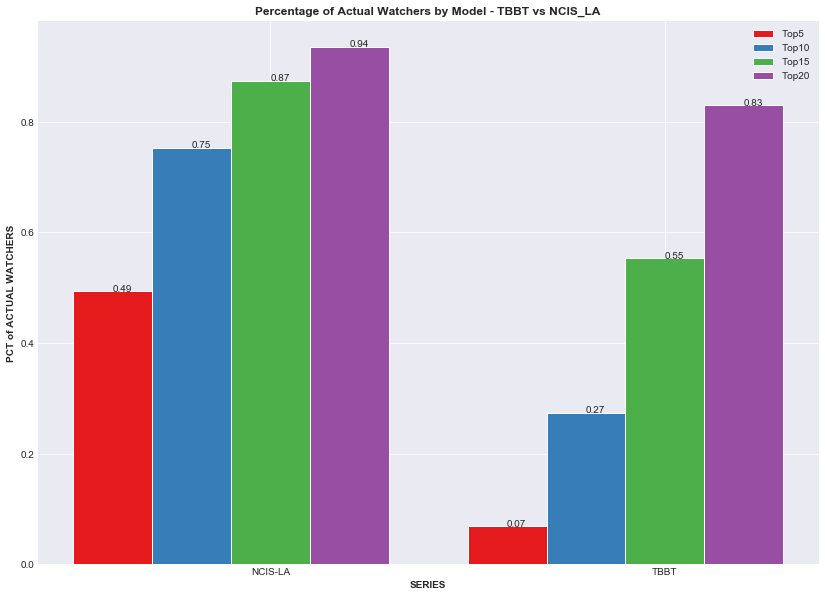

In [293]:
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("NCIS: Los Angeles")
final_df = pd.DataFrame(present_or_not_df_in_mat[present_or_not_df_in_mat.columns[present_or_not_df_in_mat.columns != 'watched']].sum().reset_index())
final_df.columns = ['name','sum']
original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
final_df['original'] = [original_watchers for i in range(len(final_df))]
final_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in final_df.name ]

top5_data = [name_val.endswith('_Top5') for name_val in final_df.name]
top10_data = [name_val.endswith('_Top10') for name_val in final_df.name]
top15_data = [name_val.endswith('_Top15') for name_val in final_df.name]
top20_data = [name_val.endswith('_Top20') for name_val in final_df.name]

final_df['pct'] = final_df['sum']/final_df['original']
final_top5_data = final_df[top5_data].reset_index()
final_top10_data = final_df[top10_data].reset_index()
final_top15_data = final_df[top15_data].reset_index()
final_top20_data = final_df[top20_data].reset_index()


final_top5_data_tbbt[final_top5_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top5']['pct']
final_top10_data_tbbt[final_top10_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top10']['pct']
final_top15_data_tbbt[final_top15_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top15']['pct']
final_top20_data_tbbt[final_top20_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top20']['pct']


import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.2

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0 
# set height of bar
bars1 = final_top5_data[final_top5_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top5']['pct']
bars1 = bars1.append(final_top5_data_tbbt[final_top5_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top5']['pct'])
bars2 = final_top10_data[final_top10_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top10']['pct']
bars2 = bars2.append(final_top10_data_tbbt[final_top10_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top10']['pct'])
bars3 = final_top15_data[final_top15_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top15']['pct']
bars3 = bars3.append(final_top15_data_tbbt[final_top15_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top15']['pct'])
bars4 = final_top20_data[final_top20_data.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top20']['pct']
bars4 = bars4.append(final_top20_data_tbbt[final_top20_data_tbbt.name == 'Model_1250_topics10_w10.0_n0.1_u0.1_v_Top20']['pct'])
# bars1 = final_top5_data['pct']
# bars2 = final_top10_data['pct']
# bars3 = final_top15_data['pct']
# bars4 = final_top20_data['pct']
    
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(14,10))
# Make the plot
plt.bar(r1, bars1, width = barWidth, color=palette(num),  edgecolor='white', label='Top5')
plt.bar(r2, bars2, width = barWidth, color=palette(num+1), edgecolor='white', label='Top10')
plt.bar(r3, bars3, width = barWidth, color=palette(num+2), edgecolor='white', label='Top15')
plt.bar(r4, bars4, width = barWidth, color=palette(num+3), edgecolor='white', label='Top20')

for i,j in zip(r1,bars1):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r2,bars2):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r3,bars3):
    plt.annotate(str(round(j,2)),xy=(i,j))
for i,j in zip(r4,bars4):
    plt.annotate(str(round(j,2)),xy=(i,j))

# model_array = ['Model_'+str(i)+\
#                     str(combination_array[i][0])+"_topics"+\
#                     str(combination_array[i][1])+"_u"+\
#                     str(combination_array[i][2])+"_v"
#  for i in range(len(result_array))]
model_array = ['NCIS-LA','TBBT',]
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth*2 for r in range(len(bars1))], model_array )
plt.ylabel('PCT of ACTUAL WATCHERS',fontweight='bold', fontsize = 10) 
plt.title('Percentage of Actual Watchers by Model - TBBT vs NCIS_LA',fontweight='bold', fontsize = 12)    
plt.xlabel('SERIES',fontweight='bold', fontsize = 10)
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.savefig('/Users/krishna/Desktop/Images/CDL_Comparison.png',bbox_inches='tight')


In [265]:
import numpy as np

def apk(actual,predicted, k=10):
    predicted_new = predicted[:k] if len(predicted)>k else predicted
#     actual_new = [j for j in actual if j not in actual_zero_loc]
    actual_new = actual[:k] if len(actual)>k else actual

    score = 0.0
    num_hits = 0.0
    
    reco = []
    for i,p in enumerate(predicted_new):
        if p in actual_new and p in predicted_new:
            reco.append(1.0)
        else :
            reco.append(0.0)
    for i in range(len(reco)):
        score += reco[i] / (i+1.0)
#     print(reco,score, score/5)
    return score/min(len(actual_new), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(np.argsort(a)[::-1],np.argsort(p)[::-1],k) for a,p in zip(actual, predicted)])

In [266]:
len(result_array)

16

In [267]:
x_1 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],1) for i in range(len(result_array))]

In [268]:
x_3 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],3) for i in range(len(result_array))]

In [269]:
x_5 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],5) for i in range(len(result_array))]

In [270]:
x_10 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],10) for i in range(len(result_array))]

In [271]:
x_15 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],15) for i in range(len(result_array))]

In [272]:
x_20 = [mapk(np.array(AllData_test_run_pivot_df_Original),result_array[i],20) for i in range(len(result_array))]

In [273]:
model_array = ['Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"   \
 for i in range(len(result_array))]

In [274]:
MAP_df = pd.DataFrame({'Model': model_array, 'MAP@1': x_1, 'MAP@3': x_3, 'MAP@5': x_5,'MAP@10': x_10,'MAP@15': x_15,'MAP@20': x_20})

In [275]:
MAP_df

,Model,MAP@1,MAP@3,MAP@5,MAP@10,MAP@15,MAP@20
0,Model_050_topics0.1_w0.1_n0.1_u0.1_v,0.813141,0.468637,0.321778,0.176605,0.121846,0.094133
1,Model_150_topics0.1_w0.1_n0.1_u10.0_v,0.857239,0.480692,0.325846,0.176742,0.121745,0.093919
2,Model_250_topics0.1_w0.1_n10.0_u0.1_v,0.688795,0.399958,0.277227,0.156186,0.109400,0.085248
3,Model_350_topics0.1_w0.1_n10.0_u10.0_v,0.543464,0.359284,0.258179,0.147680,0.103195,0.079993
4,Model_450_topics0.1_w10.0_n0.1_u0.1_v,0.817608,0.474807,0.326311,0.178637,0.123211,0.095163
5,Model_550_topics0.1_w10.0_n0.1_u10.0_v,0.833979,0.468591,0.317877,0.172620,0.119281,0.092080
6,Model_650_topics0.1_w10.0_n10.0_u0.1_v,0.701498,0.405881,0.279259,0.155370,0.108251,0.084148
7,Model_750_topics0.1_w10.0_n10.0_u10.0_v,0.556102,0.367496,0.262919,0.149203,0.103791,0.080113
8,Model_850_topics10_w0.1_n0.1_u0.1_v,0.857407,0.486578,0.332664,0.181949,0.125575,0.097075
9,Model_950_topics10_w0.1_n0.1_u10.0_v,0.835896,0.486826,0.336605,0.185240,0.127718,0.098673


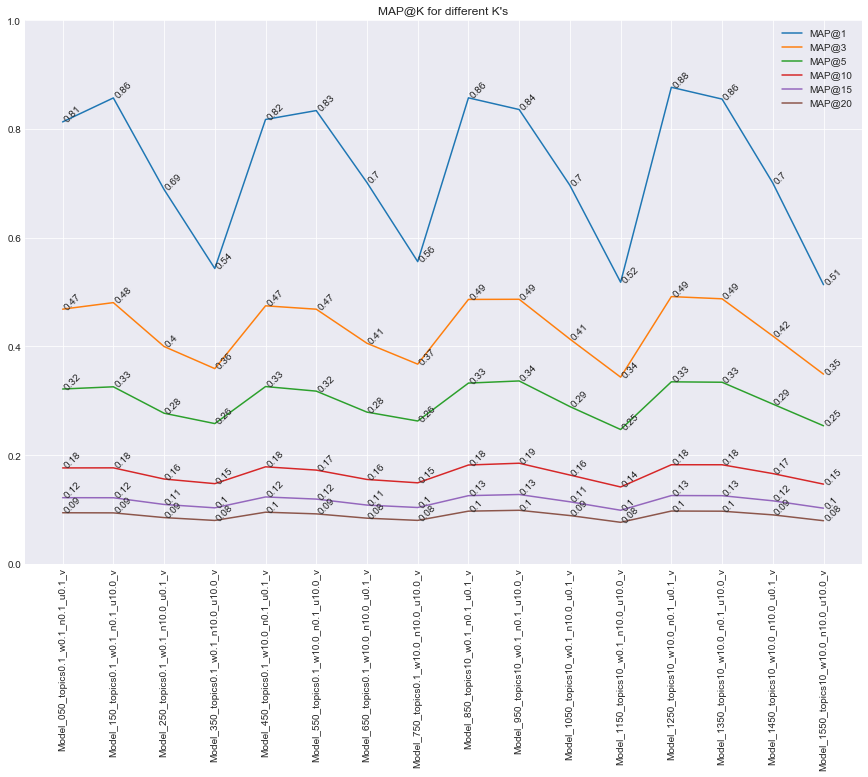

In [278]:
plt.figure(figsize=(15,10))
plt.plot('Model','MAP@1',data=MAP_df)
plt.plot('Model','MAP@3',data=MAP_df)
plt.plot('Model','MAP@5',data=MAP_df)
plt.plot('Model','MAP@10',data=MAP_df)
plt.plot('Model','MAP@15',data=MAP_df)
plt.plot('Model','MAP@20',data=MAP_df)

for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@1']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)
for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@3']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)
for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@5']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)
for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@10']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)
for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@15']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)
for i,j in zip(range(len(MAP_df.index)),MAP_df['MAP@20']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)

plt.xticks(rotation=90)
plt.title('MAP@K for different K\'s')
plt.ylim([0,1])
plt.legend()

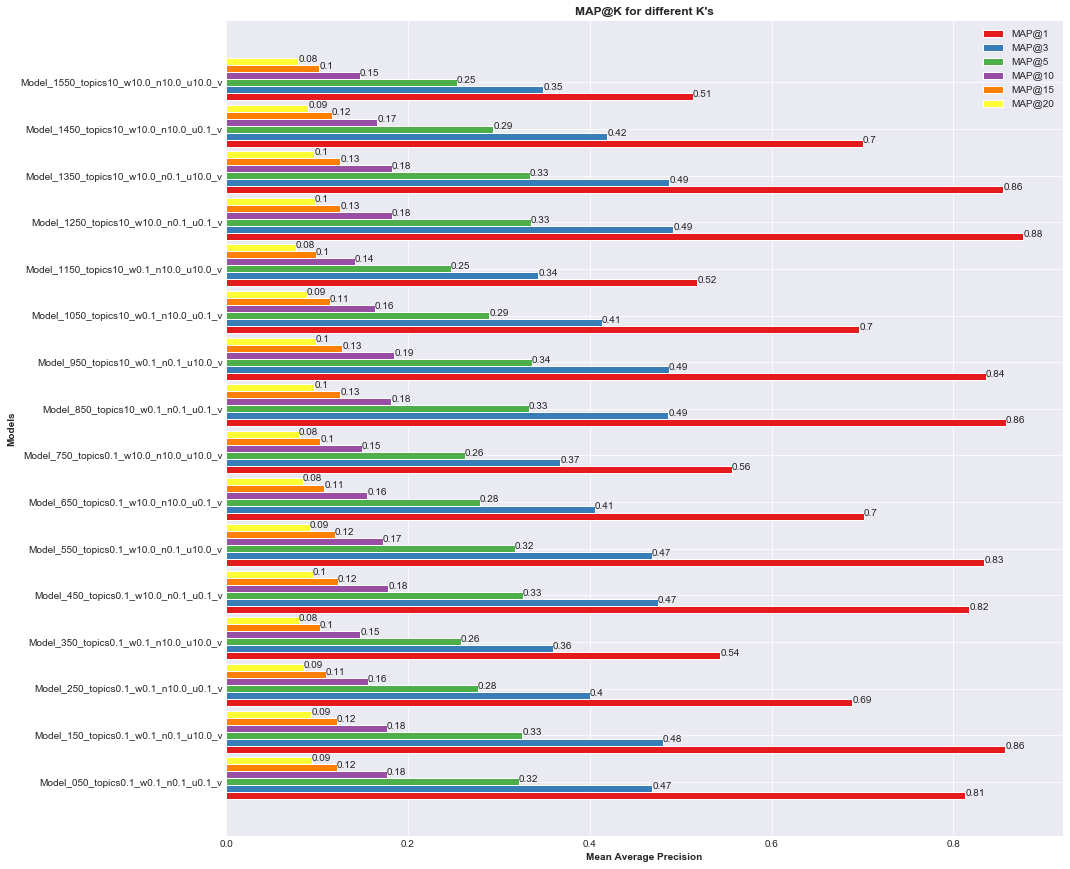

In [279]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.15

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0 
# set height of bar
bars1 = MAP_df['MAP@1']
bars2 = MAP_df['MAP@3']
bars3 = MAP_df['MAP@5']
bars4 = MAP_df['MAP@10']
bars5 = MAP_df['MAP@15']
bars6 = MAP_df['MAP@20']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

plt.figure(figsize=(15,15))
# Make the plot
plt.barh(r1, bars1, barWidth, color=palette(num), edgecolor='white', label='MAP@1')
plt.barh(r2, bars2, barWidth, color=palette(num+1), edgecolor='white', label='MAP@3')
plt.barh(r3, bars3, barWidth, color=palette(num+2), edgecolor='white', label='MAP@5')
plt.barh(r4, bars4, barWidth, color=palette(num+3), edgecolor='white', label='MAP@10')
plt.barh(r5, bars5, barWidth, color=palette(num+4), edgecolor='white', label='MAP@15')
plt.barh(r6, bars6, barWidth, color=palette(num+5), edgecolor='white', label='MAP@20')

for i,j in zip(bars1,r1):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars2,r2):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars3,r3):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars4,r4):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars5,r5):
    plt.annotate(str(round(i,2)),xy=(i,j))
for i,j in zip(bars6,r6):
    plt.annotate(str(round(i,2)),xy=(i,j))

model_array = ['Model_'+str(i)+\
                        str(combination_array[i][0])+"_topics"+\
                        str(combination_array[i][1])+"_w"+\
                        str(combination_array[i][2])+"_n"+\
                        str(combination_array[i][3])+"_u"+\
                        str(combination_array[i][4])+"_v" # +\str(combination_array[i][5])+"_epochs"   \
 for i in range(len(result_array))]
 
# Add xticks on the middle of the group bars
plt.yticks([r + barWidth*2 for r in range(len(bars1))], model_array )
plt.xlabel('Mean Average Precision',fontweight='bold') 
plt.title('MAP@K for different K\'s',fontweight='bold')   
plt.ylabel('Models',fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()


